In [11]:
from bitcoin_listener import OrderBook
import numpy
import datetime
def convert_file(text, exchange='bitstamp', lim=None):
    lim = lim if lim else len(text)
    adj_price = OrderBook.EXCHANGES[exchange]['best_shift']['price']
    adj_amount = OrderBook.EXCHANGES[exchange]['best_shift']['amount']
    lines = [l for l in text.split('\n') if l]
    list_data = []
    for line in lines:
        data = line.split('|')
        epoch = datetime.datetime.fromtimestamp(int(data[0]))
        qtd_askbid = [float(v) for v in data[1].split(' ')]
        list_asks = data[2].split(' ')[:lim]
        list_bids = data[3].split(' ')[:lim]
        list_ask_prices = numpy.cumsum([float(p.split(',')[0])/10**adj_price for p in list_asks])
        list_ask_amounts = [float(p.split(',')[1])/10**adj_amount for p in list_asks]
        list_bid_prices = numpy.cumsum([float(p.split(',')[0])/10**adj_price for p in list_bids])
        list_bid_amounts = [float(p.split(',')[1])/10**adj_amount for p in list_bids]
        list_ask_zip = list(zip(list_ask_prices, list_ask_amounts))
        list_bid_zip = list(zip(list_bid_prices, list_bid_amounts))
        list_data.append([epoch, qtd_askbid, list_ask_zip, list_bid_zip])
    return list_data

In [21]:
import gzip
import pandas
from matplotlib import pyplot as plt
%matplotlib inline

import os

source_orderbook = '/home/eol/Documents/bitcoin_compress/orderbook/'
dest = '/home/eol/Documents/bitcoin_compress/tests/'
list_exchanges = sorted(os.listdir(source_orderbook))
list_dates = [n.split('.')[0] for n in sorted(os.listdir(os.path.join(source_orderbook, 'bitstamp')))]

e = 'poloniex'
list_exchanges_filtered = [e]
list_dates_filtered = list_dates[-3:]

df_dict = {}

for exchange in list_exchanges_filtered:
    s = ''
    for date in list_dates_filtered:
        with gzip.open(os.path.join(source_orderbook, exchange, "{}.gz".format(date)),'r') as gf: 
            file_text = gf.read().decode('utf-8')
            s += file_text
        df_dict[exchange] = pandas.DataFrame(convert_file(s, lim=600), columns=['dt', 'qtd', 'asks', 'bids'])
        df_dict[exchange].set_index('dt', inplace=True, drop=True)

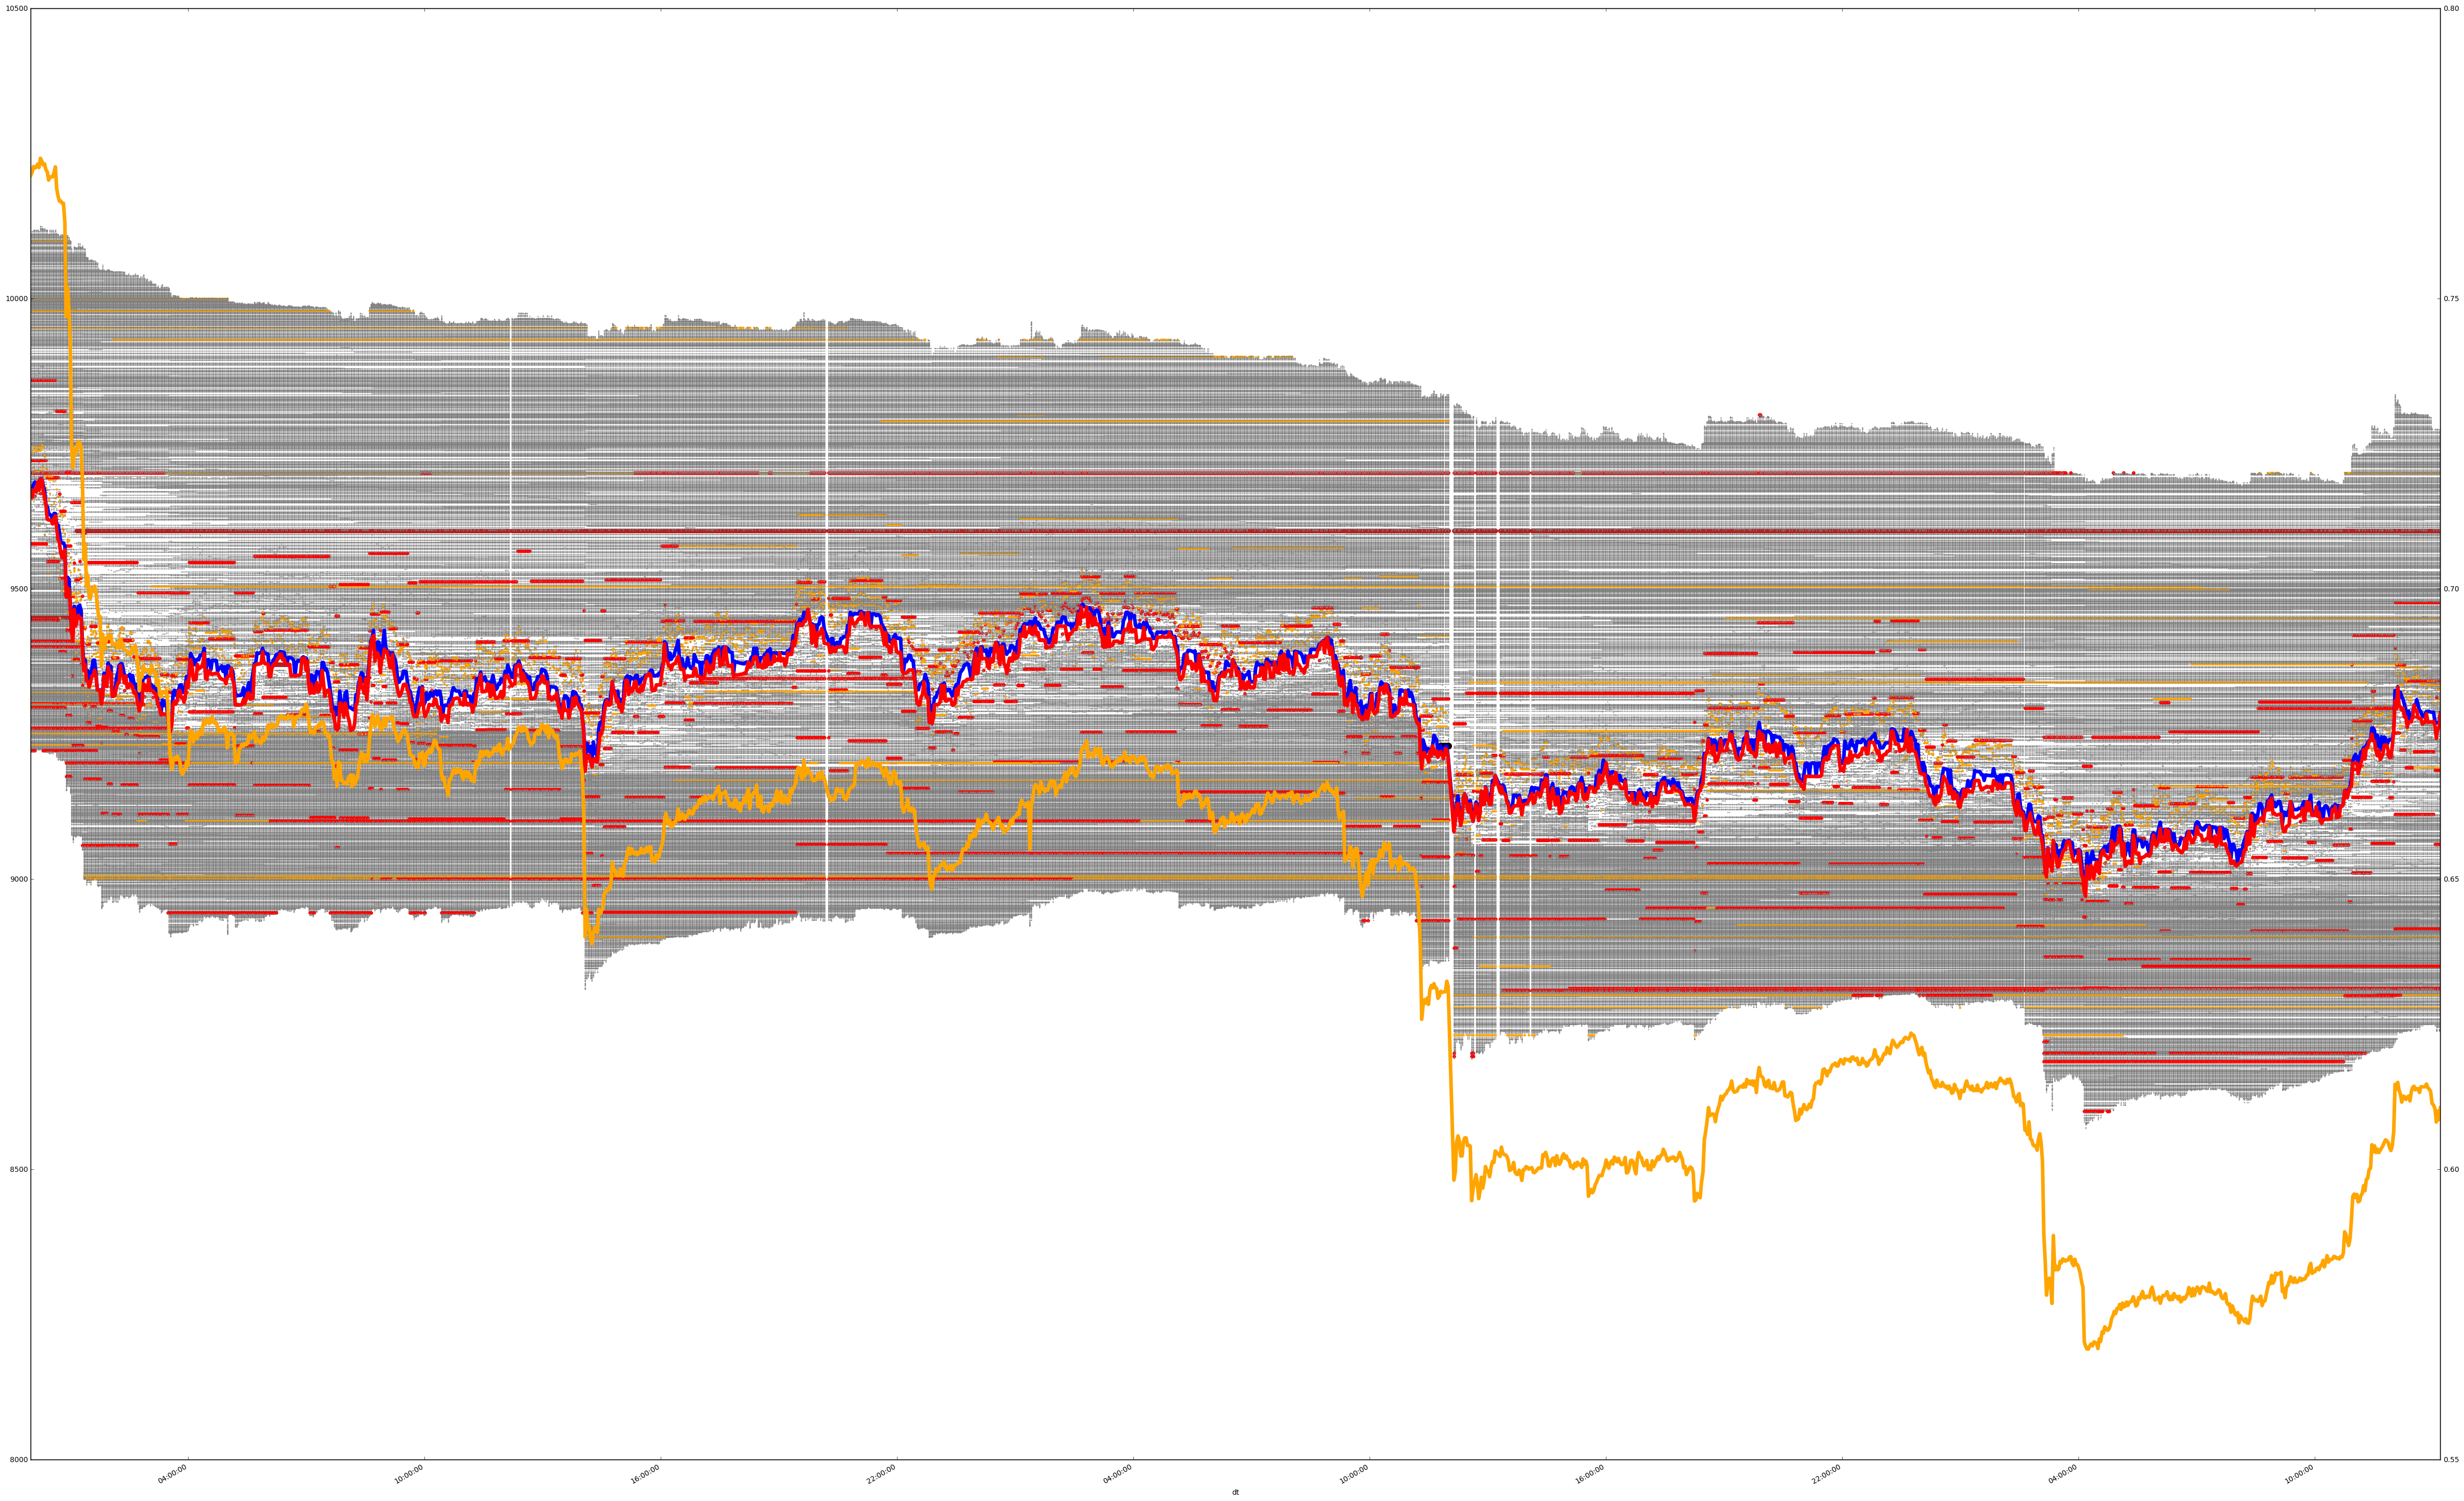

In [22]:
N=600
df_filteterd = df_dict[e].tail(3600)
plt.figure(figsize=(60,40))
#for i in range(N):
#    df_filteterd['asks'].apply(lambda d:d[i][0]).plot(alpha=0.5, lw=0.5, color='grey')
#    df_filteterd['bids'].apply(lambda d:d[i][0]).plot(alpha=0.5, lw=0.5, color='grey')

for t in ['asks', 'bids']:
    for i in range(N):
        for (m, M, s, c) in [(0,5,0.3,'grey'), (5,10,5,'orange'), (10,25,15,'red'), (25,50,30,'firebrick'), (50,75,70,'black'), (75,10000,70,'blue')]:
            try:
                d = df_filteterd[t].apply(lambda x: x[i][1])
                idx = d[(d>m)&(d<=M)].index
                if len(idx):
                    plt.scatter(idx, df_filteterd[t].apply(lambda x: x[i][0])[idx], s=s, color=c)
            except:
                pass

df_filteterd['asks'].apply(lambda d:d[0][0]).plot(lw=5, color='blue')
df_filteterd['bids'].apply(lambda d:d[0][0]).plot(lw=5, color='red')

(df_filteterd['qtd'].apply(lambda d:d[1])/df_filteterd['qtd'].apply(lambda d:d[0])).plot(lw=5, secondary_y=True, color='orange', label="fraction num orders")


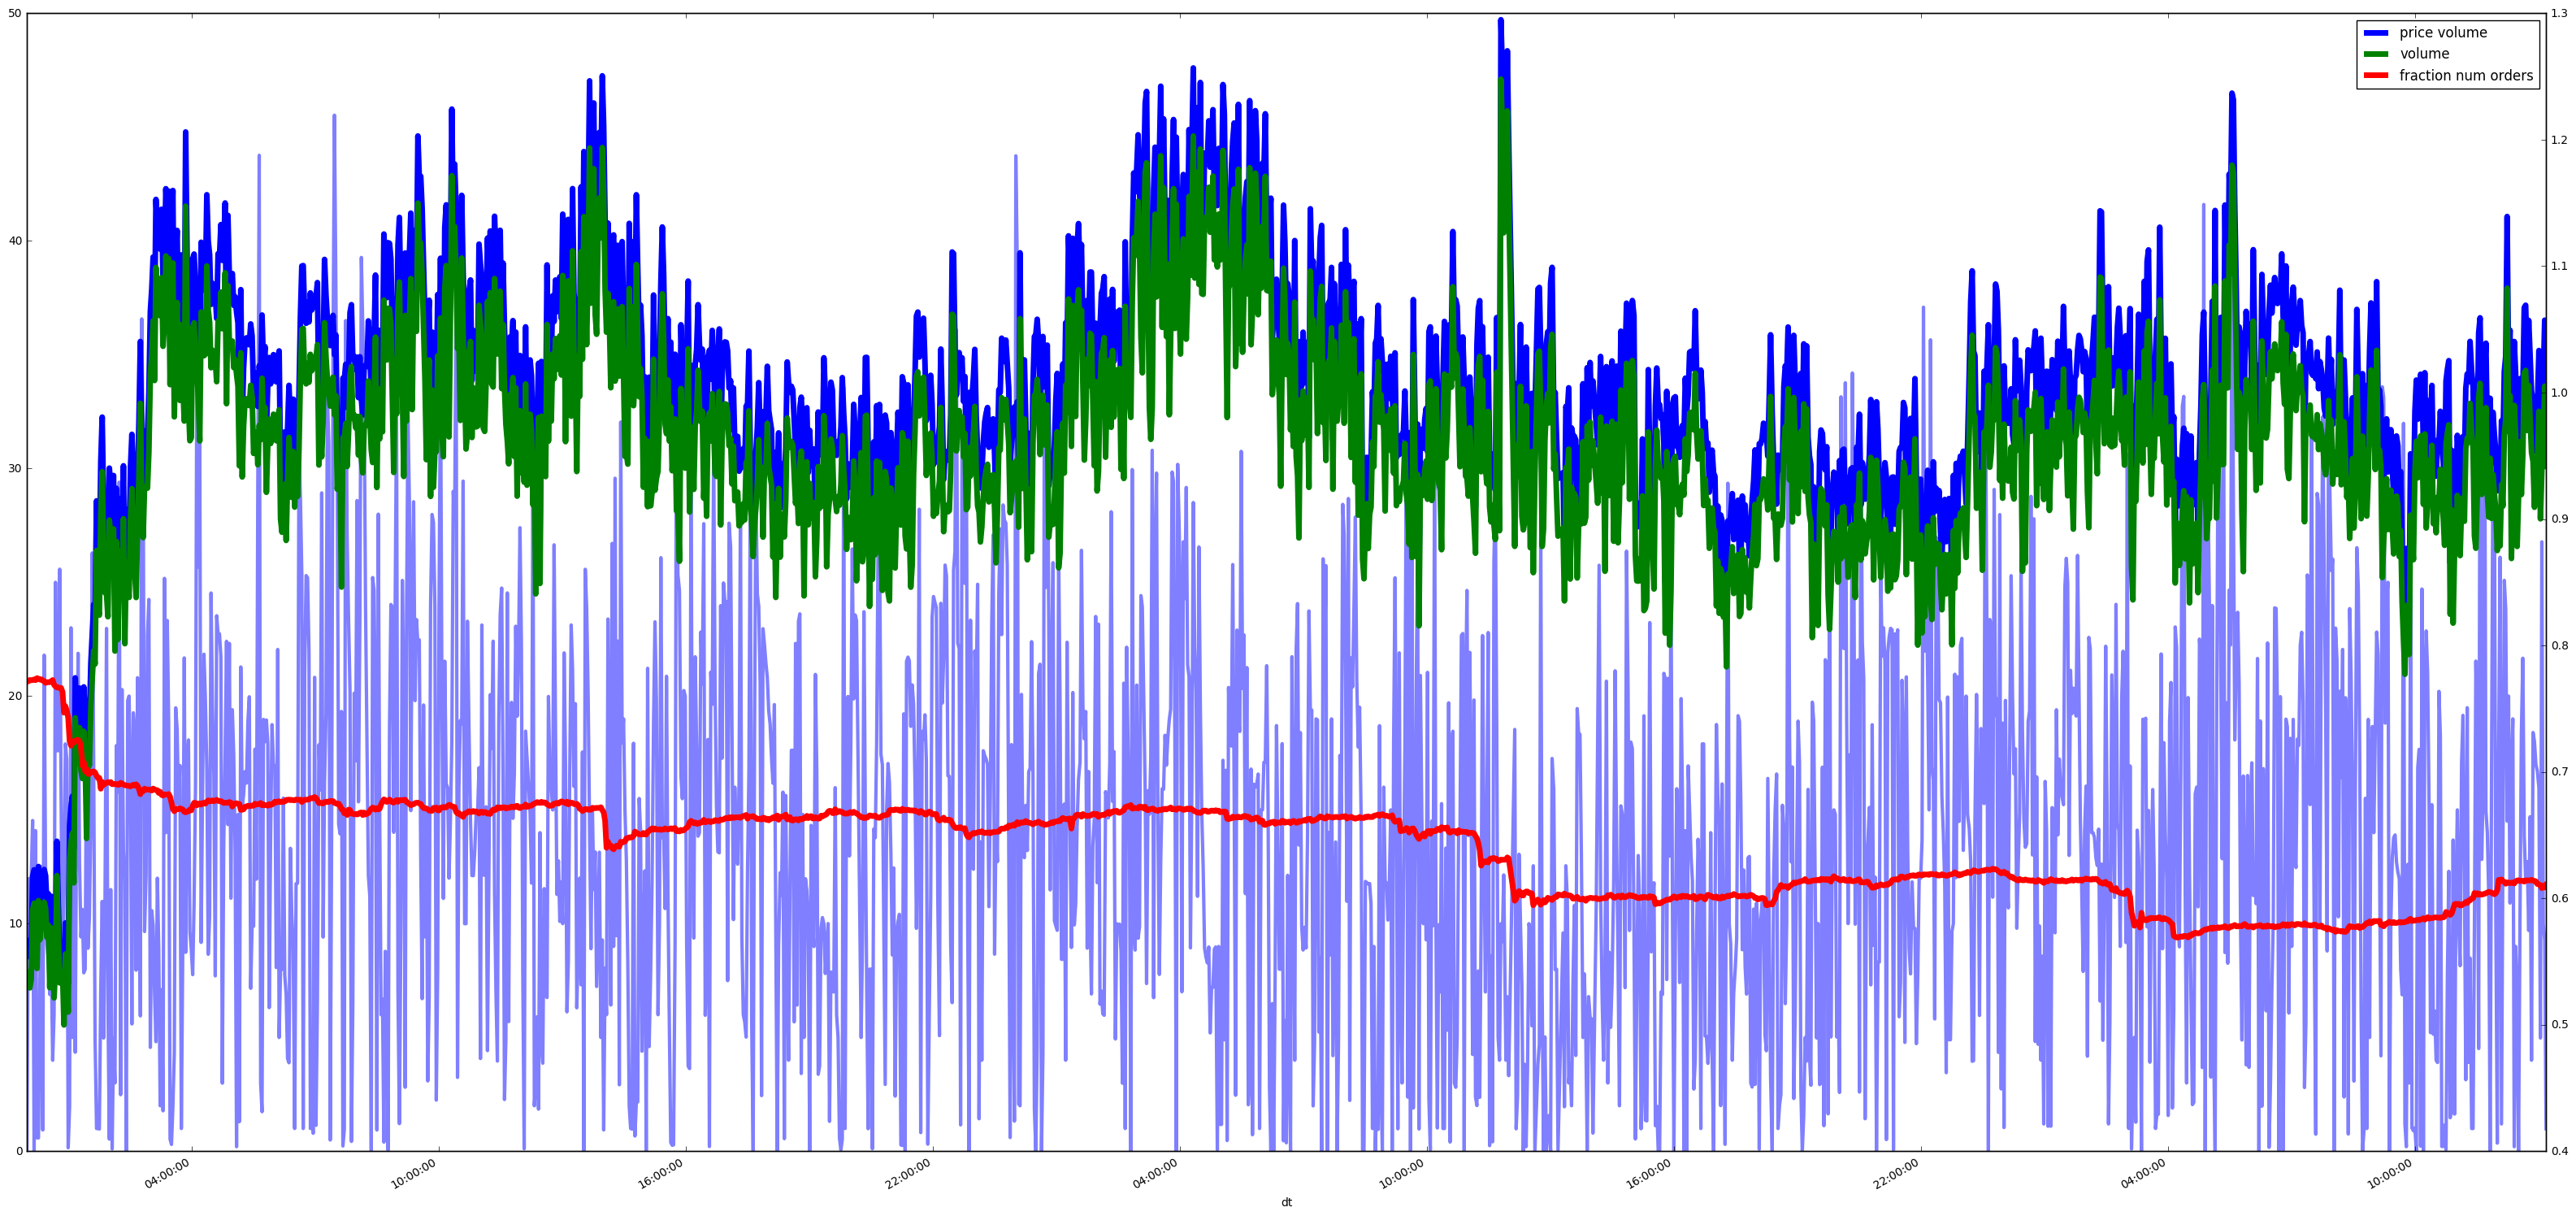

In [23]:
plt.figure(figsize=(40,20))
(df_filteterd['asks'].apply(lambda d:d[0][0])-df_filteterd['bids'].apply(lambda d:d[0][0])).plot(lw=3, alpha=0.5, color='blue', label="spread")
(df_filteterd['asks'].apply(lambda d:sum([x*y for (x,y) in d]))/df_filteterd['bids'].apply(lambda d:sum([x*y for (x,y) in d]))).plot(lw=5, secondary_y=True, label="price volume")
(df_filteterd['asks'].apply(lambda d:sum([y for (x,y) in d]))/df_filteterd['bids'].apply(lambda d:sum([y for (x,y) in d]))).plot(lw=5, secondary_y=True, label="volume")
(df_filteterd['qtd'].apply(lambda d:d[1])/df_filteterd['qtd'].apply(lambda d:d[0])).plot(lw=5, secondary_y=True, label="fraction num orders")
plt.legend()
plt.show()